In [43]:
# Import Lib
import sys
import subprocess
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import math

### Def Function
- Process Raw Data that retrieved by using Window API
- Calculate the Distance between RSS Location 

In [44]:
# Split SSIDs
def split_ssids(netsh_Result):
    SplitSSID = netsh_Result.split("\nSSID ")

    # Remove the First Array (Netsh Intro)
    SplitSSID.pop(0)

    # Splited (removed) SSID, need to add back
    for i in range(len(SplitSSID)):
        SplitSSID[i] = "SSID " + SplitSSID[i]

    return SplitSSID

In [45]:
# Get SSID Info
def get_SSID_Info(ssid_array_splited):
    # Split the String base on ":" and clean all the spacing
    ssid_Split_Space = ssid_array_splited.split("\n")
    ssid_array = []
    for i in ssid_Split_Space:
        temp = i.split(" : ")
        if len(temp) == 2:
            temp[0] = temp[0].strip()
            temp[1] = temp[1].strip()
            ssid_array.append(temp)

    # Initial a Dictionary to store info
    dic = {}
    ssid_dic = {}
    temp_arr = []
    bssid_arr = []

    # Loop each array to store the information accordingly
    for ac in range(len(ssid_array)):
        # Get SSID and store in dic
        if ssid_array[ac][0].find("SSID") != -1 & ssid_array[ac][0].find("BSSID") != 0:
            dic["SSID"] = ssid_array[ac][1]

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Network type") != -1:
            ssid_dic.update({"NetworkType": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Authentication") != -1:
            ssid_dic.update({"Authentication": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get SSID and store in dic
        elif ssid_array[ac][0].find("Encryption") != -1:
            ssid_dic.update({"Encryption": ssid_array[ac][1]})
            dic["SSID_Info"] = ssid_dic

        # Get BSSID info and store as Array
        elif ssid_array[ac][0].find("BSSID") == 0:
            if len(temp) > 0:
                bssid_arr.append(temp_arr)
                temp_arr = []
                temp_arr.append(ssid_array[ac][1])

                # when Counter reach to the end,
        elif ac == len(ssid_array) - 1:
            # Update array List
            temp_bssid = []
            bssid_arr.append(temp_arr)

            # Clean the List
            for l in bssid_arr:
                if len(l) != 0:
                    temp_bssid.append(l)

            # Write the List to Dictionary
            bssid_arr = temp_bssid
            ssid_dic.update({"BSSID_Info": bssid_arr})

        else:
            temp_arr.append(ssid_array[ac][1])

    return dic


In [46]:
# Calcualte the Distance by using Signal Strength and Channel frequency 
def get_estDistance(Frequency, Channel, SignalStrength):
    # Info Link: https://en.wikipedia.org/wiki/List_of_WLAN_channels
    # Frequency Table 2.4Ghz & 5GHz
    FT_2_4 = [[1, 2412], [2, 2417], [3, 2422], [4, 2427], [5, 2432], [6, 2437], [7, 2442], [8, 2447], [9, 2452], [10, 2457], [11, 2462], [12, 2467], [13, 2472], [14, 2484]]
    FT_5 = [[32, 5160], [34, 5170], [36, 5180], [38, 5190], [40, 5200], [42, 5210], [44, 5220], [46, 5230], [48, 5240], [50, 5250], [52, 5260], [54, 5270], [56, 5280], [58, 5290], [60, 5300], [62, 5310], [64, 5320], [68, 5340], [96, 5480], [100, 5500], [102, 5510], [104, 5520], [106, 5530], [108, 5540], [110, 5550], [112, 5560], [114, 5570], [116, 5580], [118, 5590], [120, 5600], [122, 5610], [124, 5620], [126, 5630], [128, 5640], [132, 5660],
            [134, 5670], [136, 5680], [138, 5690], [140, 5700], [142, 5710], [144, 5720], [149, 5745], [151, 5755], [153, 5765], [155, 5775], [157, 5785], [159, 5795], [161, 5805], [163, 5815], [165, 5825], [167, 5835], [169, 5845], [171, 5855], [173, 5865], [175, 5875], [177, 5885], [182, 5910], [183, 5915], [184, 5920], [187, 5935], [188, 5940], [189, 5945], [192, 5960], [196, 5980]]

    SignalStrength = abs(float(SignalStrength))
    Channel_Freq = 0

    if Frequency == "2.4 GHz":
        for i in FT_2_4:
            if i[0] == int(Channel):
                Channel_Freq = i[1]
                break
    else:
        for i in FT_5:
            if i[0] == int(Channel):
                Channel_Freq = i[1]
                break

    result = 10 ** ((27.55 - (20 * math.log10(Channel_Freq)) + SignalStrength) / 20)
    return result

In [47]:
# Convert Signal Strength In precentage to dBm
def get_SignalStrength(rssi):
    if (float(rssi<=0)):
        dbm = 100
    elif (float(rssi)>100):
        dbm = -50
    else:
        dbm = float(rssi)/2-100
    return dbm


In [48]:
# Identify the SSID Frequency by using channel 
# (Within Australia, Legal 2.4GHz WIFI Frequency must be within 1 - 13 and larger than Channel 14 must be 5GHz Frequency)
def get_frequency(Channel):
    if int(Channel) <= 14:
        ssid_frequency = "2.4 GHz"
    else:
        ssid_frequency = "5 GHz"

    return ssid_frequency

In [49]:
# Clean Up the Data And store it
def Pre_Analysis(content):
    overall_dic = []
    Splited_SSID = split_ssids(content)
    for i in range(len(Splited_SSID)):
        SSID_Info = get_SSID_Info(Splited_SSID[i])
        overall_dic.append(SSID_Info)

    table_Array = []
    for i in range(len(overall_dic)):
        ssid = overall_dic[i]["SSID"]
        for j in range(len(overall_dic[i]["SSID_Info"]["BSSID_Info"])):
            if len(overall_dic[i]["SSID_Info"]["BSSID_Info"][j]) > 3:
                BSSID = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][0]
                Signal = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][1]
                Channel = overall_dic[i]["SSID_Info"]["BSSID_Info"][j][3]
                ssid_frequency = get_frequency(Channel)
                ssid_SignalStrength = get_SignalStrength(float(Signal.replace("%", "")))
                est_Distance = get_estDistance(ssid_frequency, Channel, ssid_SignalStrength)
                temp = [ssid, BSSID, ssid_frequency, Channel, est_Distance]
                table_Array.append(temp)

    return table_Array

In [50]:
# Read the all the dataset and retrieve Same SSID with Same BSSID and Frequency but only get the Average Distance for comparison
def readMultiDB(Filepath, fileDataset, dbfilename):    
    # Result => Get the first dataset and use it to compare with other dataset 
    temp = Pre_Analysis(open(os.path.join(Filepath, fileDataset[0], db), 'r').read())
    result = []
    
    for i in range(1, len(fileDataset)):
        # Read the new Dataset 
        fread = open(os.path.join(Filepath, fileDataset[i], db), 'r').read()
        tempResult = Pre_Analysis(fread)
        
        # Loop temp dataset and compare the value and get the average Distance Value
        for i in temp:
            for j in tempResult:
                if (i[0] == j[0] and i[1] == j[1] and i[2] == j[2]):                    
                    i[4]= (i[4] + j[4])/2
                    result.append(i)
                    
        # After finish Comparing Temp with another Dataset -> Update temp 
        temp = result
        result = []
        
    # Get the Most Updated Temp
    result = temp
    
    return result

In [51]:
# https://hlab.stanford.edu/brian/euclidean_distance_in.html#:~:text='n'%2DDimensional%20Euclidean%20Distance&text=Euclidean%20distance%20is%20a%20measure,two%20points%20in%20Euclidean%20space.&text=In%20an%20example%20where%20there,is%20only%201%20Dimensional%20space.
# Multi N Dimensional Distance
def NDD(arr1, arr2):

    # If the Array size are not match, then return error
    if len(arr1) != len(arr2):
        return "ERROR"

    # Calculate the Sum
    tempsum = 0
    for i in range(len(arr1)):
        tempsum = tempsum + (arr1[i]-arr2[i])**2

    # Calculate the Result
    distance = math.sqrt(tempsum)

    return distance

In [52]:
# Search the lowest distance and distance the File name
def searchLowestDistance(Array):
    lowestIndex = -1
    tempLow = math.inf
    for i in range(len(Array)):
        if(tempLow > Array[i][1]):
            tempLow = Array[i][1]
            lowestIndex = i  
    return Array[lowestIndex][0]

### Project Testing Environment & Analysis
- Burwood Westfield level 2 (Kmart area) 
- This Dataset Collection Done after the Experiment 1. Due to Burwood Coles area with a lot of foot traffic, its inconvenient for dataset collection, At the meantime minimize the Hotspoint WIFI interference

</br></br>
 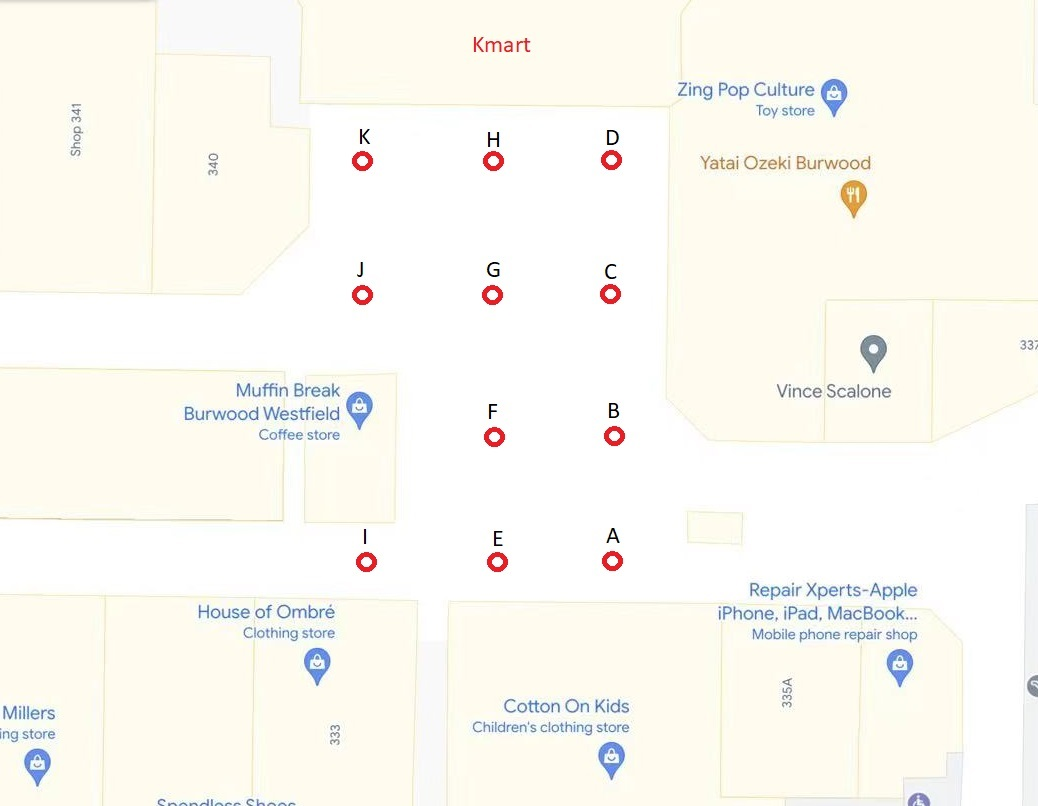
<div style="text-align: right"> <b>Credit to Google Map    </b></div>

In [53]:
# Dataset_1 Dataset (Collect at 22/07/2022 - 9:29pm ~ 10:00pm)
# Dataset_2 Dataset (Collect at 23/07/2022 - 9:00pm ~ 9:30pm)
# Read Project Dataset
ProjectDataset_RootFile = "BurwoodL3 DataCollection"
Dataset_1 = "Dataset_1"
DS1_filePath = os.path.join(ProjectDataset_RootFile, Dataset_1)

# Show Data
ep1_datasetname = []
NO_SSID = []
NO_BSSID = []
NO_2d4GHz = []
NO_5GHz = []
Dataset_1_Info = []
Dataset_1_2d4_info = []

# Loop file name and append to "ep1_datasetname"
for i in os.listdir(DS1_filePath):
    # Temporary Counter
    SSID_Counter = []
    BSSID_Counter = 0
    f_2d4Ghz = 0
    f_5Ghz = 0
    TempFre_2d4 = [0]*14
    
    # Join path
    final_path = os.path.join(DS1_filePath, i)
    DS_File = open(final_path, 'r').read()
    result = Pre_Analysis(DS_File)
    
    # Number of BSSID 
    BSSID_Counter = len(result)
    NO_BSSID.append(BSSID_Counter)
    
    # Number of 2.4GHz and 5GHz
    for per_bssid in result:
        # Count 2.4 Channel number
        
        # Count SSID 
        SSID_Counter.append(per_bssid[0])
        
        # Count 2_4GHz and 5GHz 
        if per_bssid[2] == "2.4 GHz":
            # Count number of 2.4 Frequency
            f_2d4Ghz+=1
            
            # Count frequency Channel number 
            TempFre_2d4[int(per_bssid[3])]+=1
            
        else:
            f_5Ghz+=1
        
    # Append Final Value
    ep1_datasetname.append(i)
    NO_SSID.append(len(list(set(SSID_Counter))))
    NO_2d4GHz.append(f_2d4Ghz)
    NO_5GHz.append(f_5Ghz)
    TempFre_2d4[0] = i[0:9]
    Dataset_1_2d4_info.append(TempFre_2d4)
    

# Append Dataset_1 location data to table 
for i in range(len(ep1_datasetname)):
    temp_arr = []
    temp_arr.append(ep1_datasetname[i])
    temp_arr.append(NO_SSID[i])
    temp_arr.append(NO_BSSID[i])
    temp_arr.append(NO_2d4GHz[i])
    temp_arr.append(NO_5GHz[i])
    
    Dataset_1_Info.append(temp_arr)

Dataset_1_info_head = ["Filename","NO. SSID", "NO. BSSID", "NO. 2.4GHz", "NO. 5GHz"]
print("\n Dataset 1 - Information Summary: \n\n" + tabulate(Dataset_1_Info, headers=Dataset_1_info_head) + "\n\n")

Dataset_1_2d4_head = ["Location","CH 1", "CH 2", "CH 2", "CH 4","CH 5", "CH 6", "CH 7", "CH 8","CH 9", "CH 10", "CH 11", "CH 12", "CH 13", "CH 14"]
print("\n Dataset 1 - 2.4 Frequency Channel Count': \n\n" + tabulate(Dataset_1_2d4_info, headers=Dataset_1_2d4_head) + "\n\n")



 Dataset 1 - Information Summary: 

Filename         NO. SSID    NO. BSSID    NO. 2.4GHz    NO. 5GHz
-------------  ----------  -----------  ------------  ----------
LocationA.txt          46          132            42          90
LocationB.txt          44          122            53          69
LocationC.txt          43          108            37          71
LocationD.txt          41          105            41          64
LocationE.txt          44          125            39          86
LocationF.txt          40          108            43          65
LocationG.txt          34           99            35          64
LocationH.txt          39          139            43          96
LocationI.txt          54          131            45          86
LocationJ.txt          53          125            37          88
LocationK.txt          43          126            59          67



 Dataset 1 - 2.4 Frequency Channel Count': 

Location      CH 1    CH 2    CH 2    CH 4    CH 5    CH 6    CH 7    

## Code:

#### Array Index Describtion 
    # Result[i][0]: SSID 
    # Result[i][1]: BSSID 
    # Result[i][2]: Frequency (2.4 Or 5 GHz)
    # Result[i][3]: Frequency Channel 
    # Result[i][4]: Calculated Distance 

In [54]:
# Load the test Data Set and compare to the Location Data Collection 

## Load Test Set
Test_FilePath = "BurwoodL3 TestData"
Filename = os.listdir(Test_FilePath)[1]

TestPathJoin = os.path.join(Test_FilePath, Filename)

test_fread = open(TestPathJoin, 'r').read()

result = Pre_Analysis(test_fread)

print(Filename)
# Table_head = ["SSID", "BSSID", "Frequency", "Channel", "Signal Strength", "Est. Distance (m)"]
# print(tabulate(result, headers=Table_head, tablefmt='orgtbl'))

Test2.txt


In [55]:
# Path Location 
Filepath = "BurwoodL3 DataCollection"

fileDataset = []
fileDBName = []

# Obtain how many dataset and store 
for fileName in os.listdir(Filepath):
    fileDataset.append(fileName)
    
# Obtain Selected Point Location 
for fileDBname in os.listdir(Filepath + "/" + fileDataset[0]):
    fileDBName.append(fileDBname)

# Loop db
for db in fileDBName:
    print(len(readMultiDB(Filepath, fileDataset, db)))


132
122
108
105
125
108
99
139
131
125
126


In [56]:
# Loop Database Data collection and show the cloest Location 
DB_RootFile = "BurwoodL3 DataCollection"
DB_Dataset = "Dataset_1"
Database_FilePath = os.path.join(DB_RootFile, DB_Dataset)

# Store Data
StoreDistance = []

for filename in os.listdir(Database_FilePath):
    DatabasePathJoin = os.path.join(Database_FilePath, filename)
    db_fread = open(DatabasePathJoin, 'r').read()
    result2 = Pre_Analysis(db_fread)
    
    # Temp Variable
    temp_arr1 = []
    temp_arr2 = []

    distance1 = []
    distance2 = []

    # Run the test Data and compare with the Dataset
    for i in range(len(result)):
        for j in range(len(result2)):
            if result[i][0] == result2[j][0] and result[i][1] == result2[j][1] and result[i][2] == result2[j][2]:
                distance1.append(result[i][4])
                distance2.append(result2[j][4])
                temp_arr1.append(result[i])
                temp_arr2.append(result2[j])
            
    StoreDistance.append([filename, NDD(distance1, distance2)])
    

print(StoreDistance)
print(searchLowestDistance(StoreDistance))

[['LocationA.txt', 275.1866094940117], ['LocationB.txt', 430.2675332286004], ['LocationC.txt', 351.73336054904985], ['LocationD.txt', 593.6440701058768], ['LocationE.txt', 205.3024174198748], ['LocationF.txt', 277.84680598337843], ['LocationG.txt', 348.82737291241114], ['LocationH.txt', 590.885486663686], ['LocationI.txt', 190.86831151519678], ['LocationJ.txt', 94.96569067551363], ['LocationK.txt', 139.84378302572392]]
LocationJ.txt


#### Explaination: 
    - Due to the 5GHz signal fluctuating a lot if any obstacle, for example if human body block the 5GHz signal antennas can end up causing 30 meters or more deviation. The best method to detect the WIFI location is using a 2.4 GHz frequency when there are a lot of obstacles exist.
    - 5GHz Frequency is suitable for small and open areas located (need to ensure 5GHz frequency signal receivers signal will not be blocked). 
    - 2.4 GHz and 5 GHz 

## Experiment: Indicate WIFI Fingerprinting Issue 

#### Experiment 1: RSS Value in different Time
 - This experiment done at Burwood Westfield shopping center Ground Floor (In front of Coles)
 - The dataset collection at "22/07/2022 9:02:00pm"

In [57]:
# Read Experiment Path 
## Load Test Set
Experiment_RootFile = "Experiment dataset"
ep1_filename = "Experiment 1 - RSS Value in different Time"
ep1_filepathJoin = os.path.join(Experiment_RootFile, ep1_filename)

# Show Data
ep1_datasetname = []
NO_SSID = []
NO_BSSID = []
NO_2d4GHz = []
NO_5GHz = []


# Loop file name and append to "ep1_datasetname"
for i in os.listdir(ep1_filepathJoin):
    # Temporary Counter
    SSID_Counter = []
    BSSID_Counter = 0
    f_2d4Ghz = 0
    f_5Ghz = 0
    
    # Join path
    final_path = os.path.join(ep1_filepathJoin, i)
    ep1_file = open(final_path, 'r').read()
    result = Pre_Analysis(ep1_file)
    
    # Number of BSSID 
    BSSID_Counter = len(result)
    NO_BSSID.append(BSSID_Counter)
    
    # Number of 2.4GHz and 5GHz
    for per_bssid in result:
        # Count SSID 
        SSID_Counter.append(per_bssid[0])
        
        # Count 2_4GHz and 5GHz 
        if per_bssid[2] == "2.4 GHz":
            f_2d4Ghz+=1
        else:
            f_5Ghz+=1
    
    ep1_datasetname.append(i)
    NO_SSID.append(len(list(set(SSID_Counter))))
    NO_2d4GHz.append(f_2d4Ghz)
    NO_5GHz.append(f_5Ghz)
    


tabulate_Table = []
for i in range(len(ep1_datasetname)):
    temp_arr = []
    temp_arr.append(ep1_datasetname[i])
    temp_arr.append(ep1_datasetname[i][9])
    temp_arr.append(NO_SSID[i])
    temp_arr.append(NO_BSSID[i])
    temp_arr.append(NO_2d4GHz[i])
    temp_arr.append(NO_5GHz[i])
    
    tabulate_Table.append(temp_arr)

Table_head = ["Filename", "Waited time (mins)","NO. SSID", "NO. BSSID", "NO. 2.4GHz", "NO. 5GHz"]
print("\n" + tabulate(tabulate_Table, headers=Table_head, tablefmt='orgtbl'))
print("\nNumber of SSID and BSSID getting stable after 2 mins of waited time by using Window API, for the actual Data collect of the project should wait around 2 mins before RSS data collection.")


| Filename       |   Waited time (mins) |   NO. SSID |   NO. BSSID |   NO. 2.4GHz |   NO. 5GHz |
|----------------+----------------------+------------+-------------+--------------+------------|
| 22072022_0.txt |                    0 |         53 |         126 |           60 |         66 |
| 22072022_1.txt |                    1 |         36 |          61 |           41 |         20 |
| 22072022_2.txt |                    2 |         24 |          48 |           32 |         16 |
| 22072022_3.txt |                    3 |         24 |          46 |           31 |         15 |
| 22072022_4.txt |                    4 |         25 |          44 |           30 |         14 |
| 22072022_7.txt |                    7 |         26 |          44 |           31 |         13 |

Number of SSID and BSSID getting stable after 2 mins of waited time by using Window API, for the actual Data collect of the project should wait around 2 mins before RSS data collection.


#### Experiment 2: Compare the distance between Stable Dataset and test dataset
 - Burwood Westfield level 2 (Kmart area)
 - The Detection point x 4 - Use dataset 2 (RSS collection at location and wait 3 mins)
 - The Testing Point (Unstable) x 2 - I will walk to the location and run the Window API right away
 - The Testing Point (Stable) x 2 - RSS Collection with minimum of 2 minutes of wait time
 
 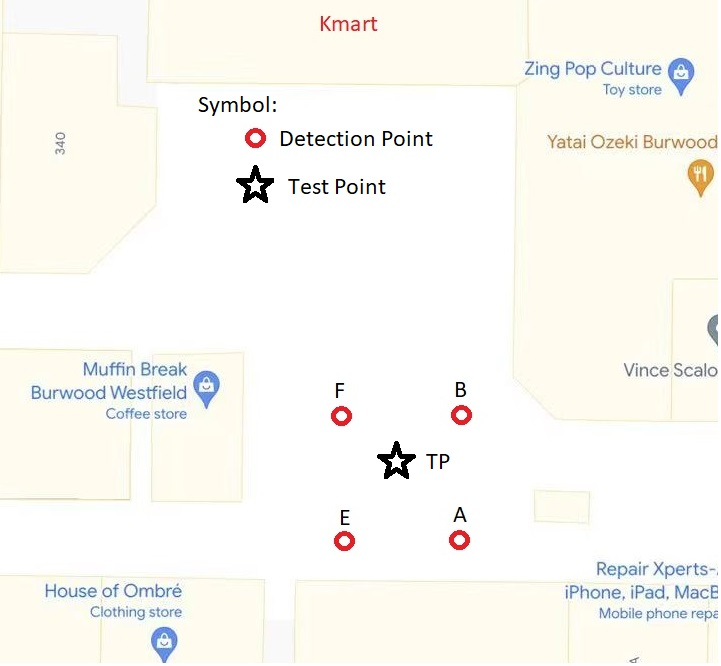